## Update a Wflow model: forcing

Once you have a **Wflow** model, you may want to update your model in order to use a new landuse map, change a parameter value, add sample locations, use different forcing data, create and run different scenarios etc.

With HydroMT, you can easily read your model and update one or several components of your model using the **update** function of the command line interface (CLI). Here are the steps and some examples on how to **update the model forcing**.

All lines in this notebook which starts with ! are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste them in your shell to get more feedback.

### Import packages

In this notebook, we will use some functions of HydroMT to plot the precipitation from the original and updated models. Here are the libraries to import to realize these steps.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

### Model setup configuration

Updating landuse is an easy step with the command line but sometimes, for example with forcing, you want to update several things at the same time. This is possible by preparing a **configuration file** that includes every methods and settings that you want to do during your update.

The HydroMT configuration file (YAML) contains the model setup configuration and determines which methods are updated and in which sequence and sets optional arguments for each method. This configuration is passed to hydromt using `-i <path_to_config_file>`.

Each header (without indent) (e.g. `setup_precip_forcing:`) corresponds with a model method which are explained in the [docs (model methods)](https://deltares.github.io/hydromt_wflow/latest/user_guide/wflow_model_setup.html).

Let's open the example configuration file **wflow_update_forcing.yml** from the model repository [examples folder] and have a look at the settings.

In [2]:
fn_config = "wflow_update_forcing.yml"
with open(fn_config, "r") as f:
    txt = f.read()
print(txt)

setup_config:                  # options parsed to wflow toml file <section>.<option>
  starttime: 2010-02-01T00:00:00
  endtime: 2010-02-10T00:00:00
  timestepsecs: 86400
  input.path_forcing: inmaps-chirps.nc

setup_precip_forcing:
  precip_fn: chirps_global # source for precipitation.

setup_temp_pet_forcing:
  temp_pet_fn: era5          # source for temperature and potential evapotranspiration.
  press_correction: True          # if True temperature is corrected with elevation lapse rate.
  temp_correction: True          # if True pressure is corrected with elevation lapse rate.
  dem_forcing_fn: era5_orography # source of elevation grid corresponding to temp_pet_fn. Used for lapse rate correction.
  pet_method: debruin       # method to compute PET: {debruin, makkink}
  skip_pet: False         # if True, only temperature is prepared.

write_forcing:                # Write forcing and re-write config if forcing filename or times are updated
  freq_out: M             # Set frequency

Here we can see that to fully update wflow forcing, we will run three methods of **Wflow**:

- **setup_config**: modifies the Wflow TOML configuration file and tells hydroMT what are the start, end, timestep of the forcing data we want to prepare. Note that you can change any options in the TOML file here, including for example the name of the output forcing file with the option *input.path_forcing*.
- **setup_precip_forcing**: tells hydroMT how to prepare precipitation data including from which data source and with or without downscaling.
- **setup_temp_pet_forcing**: tells hydroMT how to prepare temperature and potential evapotranspiration data including which data source, which computation method for PET and with or without downscaling.

We also decide to not write our forcing not as one file but one file per month.

You can find more information on the different methods and their options in the [docs (model methods)](https://deltares.github.io/hydromt_wflow/latest/user_guide/wflow_model_setup.html).

Here we can see that we will prepare daily forcing for 10 days in February 2010 using CHIRPS for precipitation and ERA5 for temperature and potential evapotranspiration.

### HydroMT CLI update interface

Using the **HydroMT build** API, we can update one or several components of an already existing Wflow model. Let's get an overview of the available options:

In [3]:
# Print the options available from the update command
! hydromt update --help

Usage: hydromt update [OPTIONS] MODEL MODEL_ROOT

  Update a specific component of a model.

  Set an output directory to copy the edited model to a new folder, otherwise
  maps are overwritten.

  Example usage: --------------

  Update (overwrite!) landuse-landcover based maps in a Wflow model: hydromt
  update wflow /path/to/model_root -c setup_lulcmaps --opt lulc_fn=vito -d
  /path/to/data_catalog.yml -v

  Update Wflow model components outlined in an .yml configuration file and
  write the model to a directory: hydromt update wflow /path/to/model_root  -o
  /path/to/model_out  -i /path/to/wflow_config.yml  -d
  /path/to/data_catalog.yml -v

Options:
  -o, --model-out DIRECTORY  Output model folder. Maps in MODEL_ROOT are
                             overwritten if left empty.
  -i, --config PATH          Path to hydroMT configuration file, for the model
                             specific implementation.
  -c, --components TEXT      Model methods from configuration file to run
 

### Update Wflow forcing layers

In [4]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt update wflow wflow_piave_subbasin -o ./wflow_piave_forcing -i wflow_update_forcing.yml -d artifact_data -v

2025-04-09 16:17:07,641 - update - log - INFO - HydroMT version: 0.10.1
2025-04-09 16:17:07,641 - update - main - INFO - Updating wflow model at C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_subbasin (r).
2025-04-09 16:17:07,641 - update - main - INFO - Output dir: C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_forcing
2025-04-09 16:17:07,641 - update - main - INFO - User settings:
2025-04-09 16:17:08,157 - update - data_catalog - INFO - Reading data catalog artifact_data latest
2025-04-09 16:17:08,157 - update - data_catalog - INFO - Parsing data catalog from C:\Users\dalmijn\.hydromt_data\artifact_data\v0.0.9\data_catalog.yml
2025-04-09 16:17:08,760 - update - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.8.0).
2025-04-09 16:17:08,760 - update - data_catalog - INFO - Parsing data catalog from C:\code\py_dev\hydromt_wflow\hydromt_wflow\data\parameters_data.yml
2025-04-09 16:17:08,787 - update - wflow - INFO - Read grid from C:\code\py_dev\hydrom

The example above means the following: run **hydromt** with:

- `update wflow`: i.e. update a wflow model
- `wflow_piave_subbasin`: original model folder
- `-o ./wflow_piave_forcing`: output updated model folder
- `-i wflow_update_forcing.yml`: setup configuration file containing the components to update and their different options
- `-d artifact_data`: specify to use the artifact_data catalog
- `v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

### Model comparison

From the information above, you can see that the different forcing variables where updated. Compared to the original model, the temperature and potential evapotranspiration still come from the ERA5 data source but now the precipitation are using CHIRPS data.

Using the script from the [plot example](https://deltares.github.io/hydromt_wflow/latest/_examples/plot_wflow_forcing.html), we can compare the two precipitation datasets together (here *basin average* values).

In [5]:
# Load both models with hydromt
from hydromt_wflow import WflowModel

mod0 = WflowModel(root="wflow_piave_subbasin", mode="r")
mod1 = WflowModel(root="wflow_piave_forcing", mode="r")

In [6]:
# read wflow forcing; mask region outside the basin and compute the basin average
# NOTE: only very limited forcing data is available from the artifacts
ds_forcing0 = xr.merge(mod0.forcing.values()).where(mod0.grid["wflow_subcatch"] > 0)
ds_forcing0 = ds_forcing0.mean(dim=[ds_forcing0.raster.x_dim, ds_forcing0.raster.y_dim])

ds_forcing1 = xr.merge(mod1.forcing.values()).where(mod1.grid["wflow_subcatch"] > 0)
ds_forcing1 = ds_forcing1.mean(dim=[ds_forcing1.raster.x_dim, ds_forcing1.raster.y_dim])

Text(0, 0.5, 'precipitation\nmm.day-1')

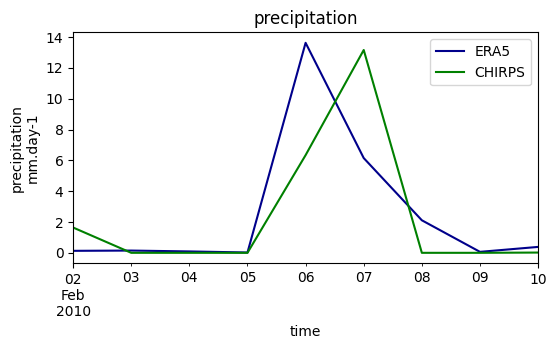

In [7]:
# plot precipitation
fig, axes = plt.subplots(1, 1, figsize=(6, 3))
df0 = ds_forcing0["precip"].squeeze().to_series()
df1 = ds_forcing1["precip"].squeeze().to_series()

# axes.bar(df1.index, df1.values, facecolor='green', label='CHIRPS')
# axes.bar(df0.index, df0.values, facecolor='darkblue', label='ERA5')

df0.plot.line(ax=axes, x="time", color="darkblue", label="ERA5")
df1.plot.line(ax=axes, x="time", color="green", label="CHIRPS")


axes.set_xlabel("time")
axes.legend()
axes.set_title("precipitation")
axes.set_ylabel("precipitation\nmm.day-1")